In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

**Data Augmentation**

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

Gets the data with size=224, bs=64, padding_mode='zeros'

In [0]:
data = get_data(224, bs, 'zeros')

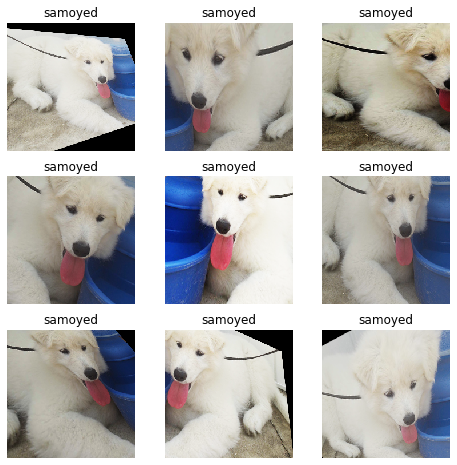

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

gets data with padding_mode='reflection'

In [0]:
data = get_data(224,bs)

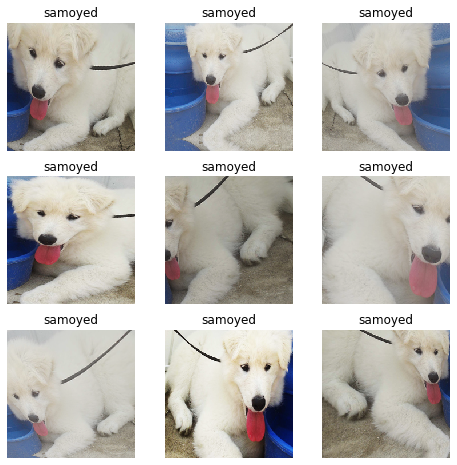

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

**Train the model**

In [12]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [13]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.627000,0.372533,0.091340,01:35
1,0.966001,0.292071,0.089310,01:38
2,0.701202,0.252521,0.075101,01:37


In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.594586,0.253128,0.065629,01:41
1,0.557489,0.239058,0.068336,01:40


**Training with a large size data**

In [0]:
data = get_data(352,bs)
learn.data = data

In [16]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.525686,0.206807,0.048714,03:00
1,0.491793,0.205189,0.045332,02:59


In [0]:
learn.save('352')

**What happens in a Convolutional Kernel**

In [0]:
data = get_data(352,16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category japanese_chin

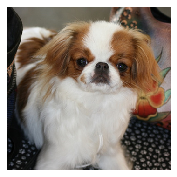

In [20]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

Defining a kernel

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [22]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

1 kernel, 3 channels , 3*3 matrix

In [23]:
k.shape

torch.Size([1, 3, 3, 3])

3 channels, 352*352 matrix

In [24]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

making it as a batch with size 1

In [25]:
t[None].shape

torch.Size([1, 3, 352, 352])

performing convolution between image and kernel

In [0]:
edge = F.conv2d(t[None], k)

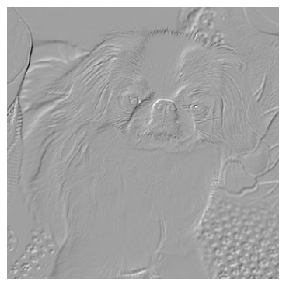

In [27]:
show_image(edge[0], figsize=(5,5));

In [28]:
data.c

37

In [29]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

**Heat Maps**

In [0]:
m = learn.model.eval();

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

Going backward to the last layer and saving the activations

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

512 channels, 11*11 matrix

In [35]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

Averaging through channels

In [36]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

extending the 11*11 matrix to the image size and imposing this matrix on to the image

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

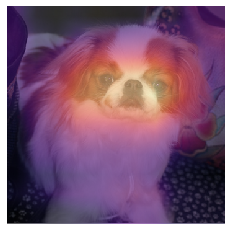

In [38]:
show_heatmap(avg_acts)